# Heart Failure Mortality: An Unsupervised Prediction Study

---

Unsupervised predictions of patient mortality from congestive heart failure using a dataset of biomarkers and comorbidities.

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
- 4.[**Exploratory Data Analysis (EDA)**](#eda)
- 5.[**Models**](#models)

- 6.[**Conclusion - Kaggle Test Set**](#conclusion)
  - 6.1.[Possible Areas for Improvement](#improvements)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


Dataset collected from patients exhibiting heart failure at Faisalabad Institute of Cardiology and Allied Hospital in Faisalabad (Punjab, Pakistan). All patients diagnosed with left ventricular systolic dysfunction and had previous heart failures.

For more detailed information see article published in PLOS One here: https://doi.org/10.1371/journal.pone.0181001

Dataset source: https://plos.figshare.com/articles/dataset/Survival_analysis_of_heart_failure_patients_A_case_study/5227684/1

**Data Info Summary:**
- Accessed and obtained on 7/1/2024.
- Data collected between April and December 2015.

- **Feature Information**
    - **Age:** Integer age of the patient.
    - **Anaemia:** Boolean of whether or not the patient's blood test results indicated anaemia.
    - **Creatine Phosphokinase (CPK):** Measurement of Creatine Phosphokinase levels measured in mcg/L during enzyme blood tests. High levels typically indicate muscle stress or injury.
    - **Diabetes:** Boolean of whether or not the patient has been diagnosed with diabetes.
    - **Ejection Fraction:** Measured as percentage of blood leaving the heart during contraction. $EF = \frac{SV}{EDV} \cdot 100$, where $EF$ is Ejection Fraction, $SV$ is Stroke Volume, and $EDV$ is End Diastolic Volume.
    - **High Blood Pressure:** Boolean of whether or not the patient has been diagnosed with high blood pressure.
    - **Platelets:** Measurement of platelet counts during platelet count test.
    - **Serum Creatinine:** Measurement of creatinine in the patient's blood stream during blood test in mg/dL.
    - **Serum Sodium:** Measurement of sodium in the patient's blood stream during blood test in mEq/L.
    - **Sex:** Binary of patient's biological sex identification (0 = Female, 1 = Male). 
    - **Smoking:** Boolean of whether or not the patient has a history of smoking.
    - **Time:** Integer of follow-up in days.
    - **Death_Event:** Boolean of whether or not the patient died during the follow-up period.

## 2. Setup <a name="setup"></a>

---

In [801]:
import os
import sys
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import kmodes
from kmodes.kprototypes import KPrototypes
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb

from sklearn.svm import SVC
# Logistical Regression

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [802]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns, kmodes, sklearn, xgb]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

Python version: 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)]
<module 'pandas'  using version: 2.1.4
<module 'numpy'  using version: 1.26.4
<module 'seaborn'  using version: 0.13.2
<module 'kmodes'  using version: 0.12.2
<module 'sklearn'  using version: 1.3.2
<module 'xgboost'  using version: 2.0.3


### 2.2. Importing the Data: <a name="dataimport"></a>

In [803]:
patient_df = pd.read_csv('./data/clinical_records.csv')

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

Print out some basic information about the dataset.

In [804]:
patient_df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


Rename some of the columns for readability and consistency.

Major changes:

- creatinine_phosphokinase to `CPK`
- high_blood_pressure to `Hypertension`
- smoking to `Smoker`
- time to `Follow_Up_Days`
- DEATH_EVENT to `Death`

In [805]:
patient_df = patient_df.rename(columns = {'age' : 'Age',
                                          'anaemia' : 'Anaemia',
                                          'creatinine_phosphokinase' : 'CPK',
                                          'diabetes' : 'Diabetes',
                                          'ejection_fraction' : 'Ejection_Fraction',
                                          'high_blood_pressure' : 'Hypertension',
                                          'platelets' : 'Platelets',
                                          'serum_creatinine' : 'Serum_Creatinine',
                                          'serum_sodium' : 'Serum_Sodium',
                                          'sex' : 'Sex',
                                          'smoking' : 'Smoker',
                                          'time' : 'Follow_Up_Days',
                                          'DEATH_EVENT' : 'Death'})

Let's now make sure the features have appropriate data types.

In [806]:
patient_df.dtypes

Age                  float64
Anaemia                int64
CPK                    int64
Diabetes               int64
Ejection_Fraction      int64
Hypertension           int64
Platelets            float64
Serum_Creatinine     float64
Serum_Sodium           int64
Sex                    int64
Smoker                 int64
Follow_Up_Days         int64
Death                  int64
dtype: object

- `Age` doesn't need to be a float.
- `Sex` being binary is a little confusing for analysis.

Here, `Age` will be changed into an integer and `Sex` will be changed into a string object for easier readability. It will be changed back to binary before model fitting since many of the models won't support that style of categorical feature.

In [807]:
# Change age to int.
patient_df.Age = patient_df.Age.astype(int)

# # Change sex from binary to strings for readability during EDA.
# patient_df.Sex = patient_df.Sex.mask(patient_df.Sex == 1, 'Male')
# patient_df.Sex = patient_df.Sex.mask(patient_df.Sex == 0, 'Female')

Now let's make sure there are no duplicates or missing entries.

In [808]:
# Check for missing values.
patient_df.isna().sum()

Age                  0
Anaemia              0
CPK                  0
Diabetes             0
Ejection_Fraction    0
Hypertension         0
Platelets            0
Serum_Creatinine     0
Serum_Sodium         0
Sex                  0
Smoker               0
Follow_Up_Days       0
Death                0
dtype: int64

In [809]:
# Check for duplicate rows.
print('Duplicates Found:', patient_df.duplicated().sum())
print('DF Shape:', patient_df.shape)

patient_df[patient_df.duplicated()]

Duplicates Found: 0
DF Shape: (299, 13)


,Age,Anaemia,CPK,Diabetes,Ejection_Fraction,Hypertension,Platelets,Serum_Creatinine,Serum_Sodium,Sex,Smoker,Follow_Up_Days,Death


Great, no missing entries or duplicate patient information was found.

Now that everything has been cleaned and cast into appropriate data types, we can begin EDA.

## 4. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

In [810]:
# Create a list of different column types for convenience.
categorical_cols = ['Anaemia','Diabetes','Hypertension','Smoker','Death']
numerical_cols = ['Age', 'CPK', 'Ejection_Fraction', 'Platelets', 'Serum_Creatinine', 'Serum_Sodium', 'Follow_Up_Days']

In [811]:
patient_df

,Age,Anaemia,CPK,Diabetes,Ejection_Fraction,Hypertension,Platelets,Serum_Creatinine,Serum_Sodium,Sex,Smoker,Follow_Up_Days,Death
0,75,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [812]:
patient_df.describe()

,Age,Anaemia,CPK,Diabetes,Ejection_Fraction,Hypertension,Platelets,Serum_Creatinine,Serum_Sodium,Sex,Smoker,Follow_Up_Days,Death
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.829431,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894997,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


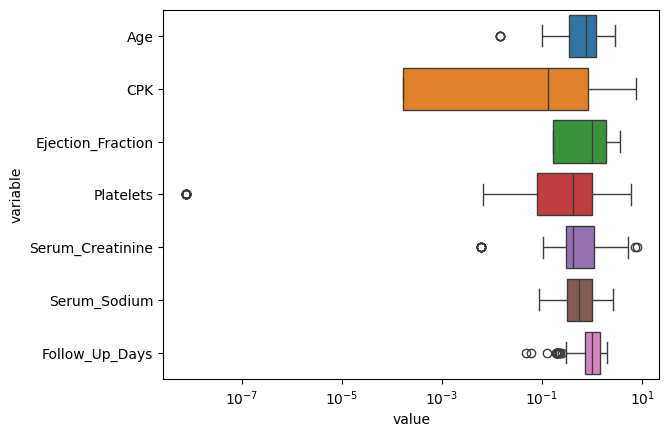

In [837]:
sns.boxplot(patient_df[numerical_cols].melt(), y = 'variable', x = 'value', hue = 'variable', log_scale=True)
plt.show()

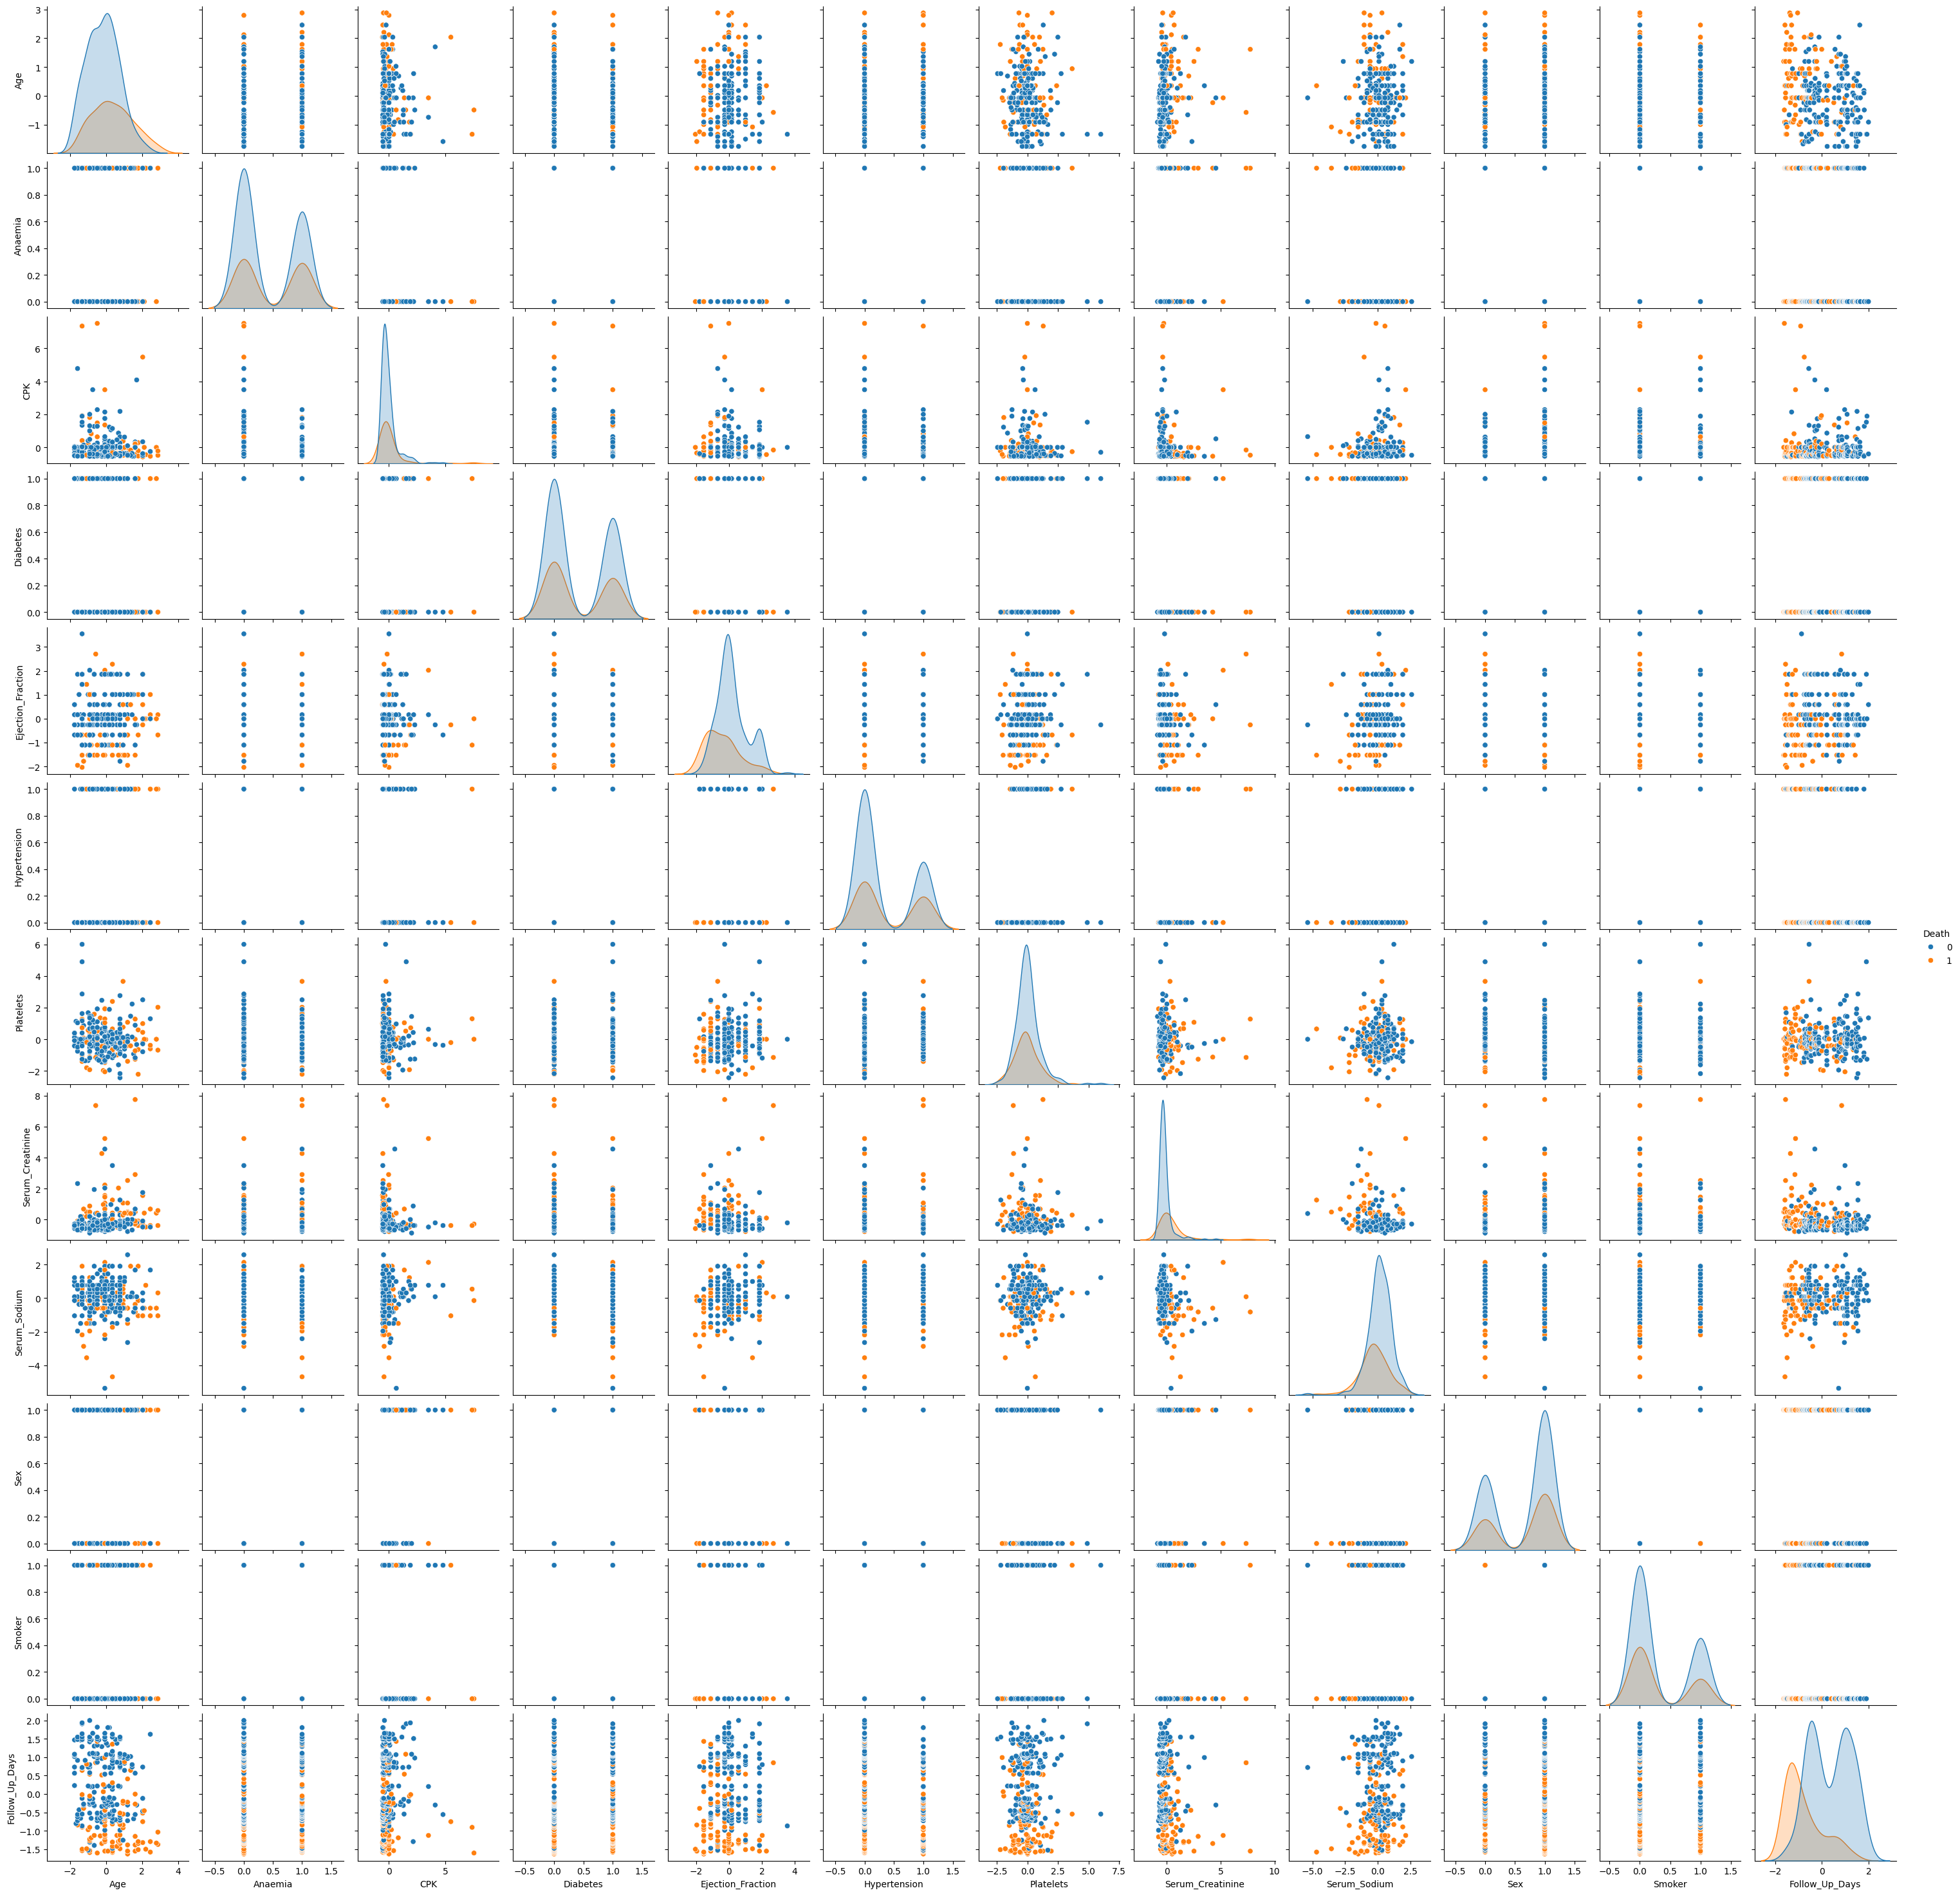

In [840]:
sns.pairplot(patient_df, hue = 'Death')
plt.show()

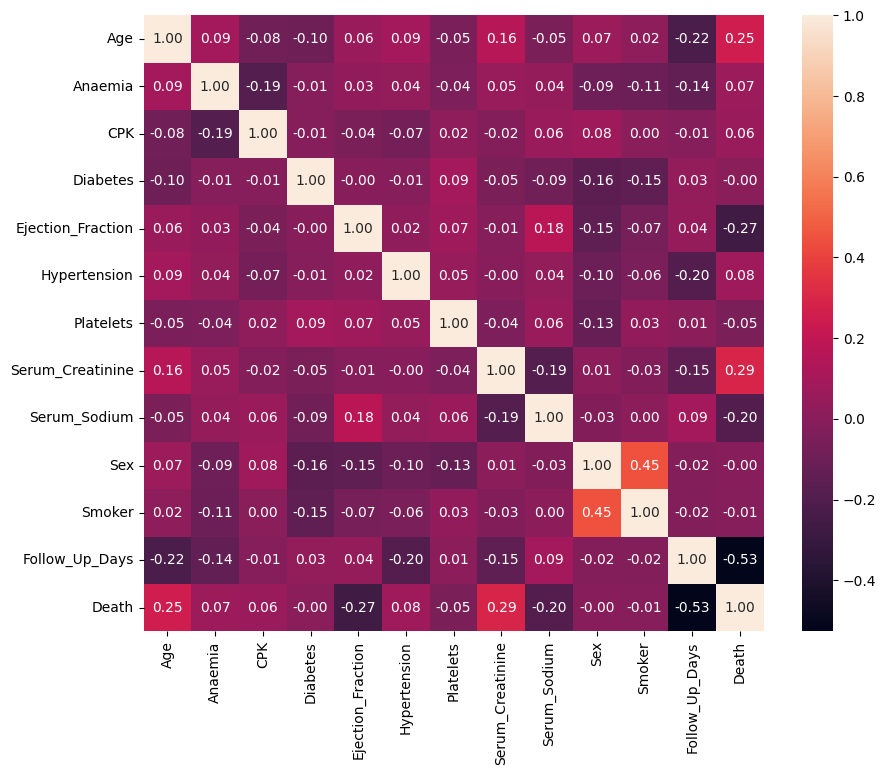

In [843]:
# Correlation
corr_matrix = patient_df.corr()
# Plot matrix.
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr_matrix, ax = ax, annot = True, fmt = '.2f')
plt.show()

Final Processing

In [816]:
# Change sex back to binary for models.
patient_df.Sex = patient_df.Sex.mask(patient_df.Sex == 'Male', 1)
patient_df.Sex = patient_df.Sex.mask(patient_df.Sex == 'Female', 0)
patient_df.Sex = patient_df.Sex.astype(int)

Talk about how scaling helps distance measures be more efficient and meaningful.

In [817]:
# numerical_cols = patient_df.select_dtypes(include = 'number').columns
scaler = StandardScaler()#MinMaxScaler()#
patient_df[numerical_cols] = scaler.fit_transform(patient_df[numerical_cols])
patient_df.head()

,Age,Anaemia,CPK,Diabetes,Ejection_Fraction,Hypertension,Platelets,Serum_Creatinine,Serum_Sodium,Sex,Smoker,Follow_Up_Days,Death
0,1.193302,0,0.000166,0,-1.530560,1,1.681648e-02,0.490057,-1.504036,1,0,-1.629502,1
1,-0.490896,0,7.514640,0,-0.007077,0,7.535660e-09,-0.284552,-0.141976,1,0,-1.603691,1
2,0.351203,0,-0.449939,0,-1.530560,0,-1.038073e+00,-0.090900,-1.731046,1,1,-1.590785,1
3,-0.911945,1,-0.486071,0,-1.530560,0,-5.464741e-01,0.490057,0.085034,1,0,-1.590785,1
4,0.351203,1,-0.435486,1,-1.530560,0,6.517986e-01,1.264666,-4.682176,0,0,-1.577879,1


Helper functions to assign the correct labels to unsupervised model predictions.

In [818]:
def unsuper_accuracy(y_pred):
    acc = accuracy_score(y_true = patient_df.Death.astype(int), y_pred = y_pred)
    return max(acc, 1-acc)

In [819]:
def check_unsuper_y_labels(y_pred):
    acc = accuracy_score(y_true = patient_df.Death.astype(int), y_pred = y_pred)
    if 1-acc > acc: #Flip labels
        return 1-y_pred
    else:
        return y_pred

## 5. Models <a name="models"></a>

---

### 5.1. Baseline Models <a name="baseline"></a>

The first baseline model is simple, equal random chance at survival.

In [852]:
mod_rand_baseline = 1 / 2
print('Random Chance Baseline Accuracy:', mod_rand_baseline)

Random Chance Baseline Accuracy: 0.5


The next option is taking the most frequent class in the dataset and always predict that class.

In [850]:
most_freq_class = patient_df.Death.value_counts(sort = True).index[0]

y_pred_freq_baseline = np.full(shape = len(patient_df), fill_value = most_freq_class)
print(y_pred_freq_baseline)
print('Most Frequent Class Baseline Accuracy:', accuracy_score(y_true = patient_df.Death.astype(int), y_pred = y_pred_freq_baseline))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Most Frequent Class Baseline Accuracy: 0.6789297658862876


### 5.3. Unsupervised Models <a name="unsuper"></a>

#### 5.3.1. K-Prototypes Clustering<a name="kproto"></a>

In [820]:
kproto = KPrototypes(n_clusters = 2,
                     max_iter = 1000,
                     n_init = 50)
y_pred_kproto = kproto.fit_predict(patient_df.iloc[:,0:12], categorical = [1, 3, 5, 9, 10])

print(unsuper_accuracy(y_pred_kproto))
y_pred_kproto = check_unsuper_y_labels(y_pred_kproto)

0.7759197324414716


In [821]:
results = classification_report(patient_df.Death.astype(int), y_pred_kproto, output_dict = True)
pd.DataFrame().from_dict(results)

,0,1,accuracy,macro avg,weighted avg
precision,0.861702,0.630631,0.77592,0.746166,0.787512
recall,0.798030,0.729167,0.77592,0.763598,0.775920
f1-score,0.828645,0.676329,0.77592,0.752487,0.779740
support,203.000000,96.000000,0.77592,299.000000,299.000000


#### 5.3.2. K-Means Clustering<a name="kmeans"></a>

In [822]:
kmeans = KMeans(n_clusters = 2,
                     max_iter = 1000,
                     n_init = 50)
y_pred_kmeans = kmeans.fit_predict(patient_df[['Age','CPK','Ejection_Fraction', 'Platelets', 'Serum_Creatinine', 'Serum_Sodium', 'Follow_Up_Days']])

print(unsuper_accuracy(y_pred_kmeans))
y_pred_kmeans = check_unsuper_y_labels(y_pred_kmeans)

0.7759197324414716


In [823]:
results = classification_report(patient_df.Death.astype(int), y_pred_kmeans, output_dict = True)
pd.DataFrame().from_dict(results)

,0,1,accuracy,macro avg,weighted avg
precision,0.861702,0.630631,0.77592,0.746166,0.787512
recall,0.798030,0.729167,0.77592,0.763598,0.775920
f1-score,0.828645,0.676329,0.77592,0.752487,0.779740
support,203.000000,96.000000,0.77592,299.000000,299.000000


#### 5.3.3. Hierarchical Clustering <a name="hier"></a>

In [824]:
def model_optimizer_hier():
    # Function to test each combination.
    def hier_cluster_fit(data, metric, linkage):
        mod_hier_cluster = AgglomerativeClustering(n_clusters = 2, metric = metric, linkage = linkage)
        mod_hier_cluster.fit(data)
        y_pred = mod_hier_cluster.labels_
        acc = unsuper_accuracy(y_pred)
        return (acc)

    # Initialize the parameter options.
    grid = {'metric' : ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
            'linkage' : ['ward', 'complete', 'average', 'single']}

    best_acc = float('-inf')
    opt_params_hier = None

    # Test each parameter.
    for link in grid['linkage']:
        # Deal with Ward having incompatible parameters.
        if link == 'ward':
            acc = hier_cluster_fit(patient_df.iloc[:,0:12], 'euclidean', link)
            if acc > best_acc:
                best_acc = acc
                opt_params_hier = ('euclidean', link)
            continue # Don't need to test remaining metrics for ward linkage.
        for met in grid['metric']:
            acc = hier_cluster_fit(patient_df.iloc[:,0:12], met, link)
            if acc > best_acc:
                best_acc = acc
                opt_params_hier = (met, link)

    print(f'Optimized:\n Combination {opt_params_hier}\n Accuracy {best_acc}')

    return (opt_params_hier)

In [825]:
opt_params_hier = model_optimizer_hier()
mod_hier = AgglomerativeClustering(n_clusters = 2, metric = opt_params_hier[0], linkage = opt_params_hier[1])
mod_hier.fit(patient_df.iloc[:,0:12])
y_pred_hier = mod_hier.labels_

Optimized:
 Combination ('euclidean', 'ward')
 Accuracy 0.7725752508361204


In [826]:
results = classification_report(patient_df.Death.astype(int), y_pred_hier, output_dict = True)
pd.DataFrame().from_dict(results)

,0,1,accuracy,macro avg,weighted avg
precision,0.789700,0.712121,0.772575,0.750910,0.764791
recall,0.906404,0.489583,0.772575,0.697994,0.772575
f1-score,0.844037,0.580247,0.772575,0.712142,0.759342
support,203.000000,96.000000,0.772575,299.000000,299.000000


### 5.4. Supervised Models <a name="super"></a>

#### 5.4.1. Train / Test Split <a name="split"></a>

Talk about class balancing, not splitting for unsupervised models, and size of dataset issues.

In [845]:
X_train, X_test = train_test_split(patient_df, train_size = 0.8, stratify = patient_df.Death, random_state = 21)

class_balance_train_s, class_balance_train_d = X_train.Death.value_counts()
class_balance_test_s, class_balance_test_d = X_test.Death.value_counts()
print('Class Ratio of Deaths to Total in Train:', class_balance_train_d / (class_balance_train_s + class_balance_train_d))
print('Class Ratio of Deaths to Total in Test:', class_balance_test_d / (class_balance_test_s + class_balance_test_d))

Class Ratio of Deaths to Total in Train: 0.32217573221757323
Class Ratio of Deaths to Total in Test: 0.31666666666666665


#### 5.4.2. XGBoost <a name="xgb"></a>

In [828]:
def model_optimizer_xgb(param_grid_xgb, train_df, k_folds = 3):
    params_permut = list(itertools.product(*param_grid_xgb.values()))  
    print(f'The number of parameter combinations to be tested: {len(params_permut)}')
    print(f'The number of models tested with cross-validation: {len(params_permut) * k_folds}')

    opt_array = np.full((len(params_permut) * k_folds, len(param_grid_xgb) + 4), fill_value = np.nan, dtype = 'O')
    opt_log_loss = float('inf')
    opt_params_xgb = None

    cross_val = KFold(n_splits = k_folds, shuffle = True)

    for i, par in enumerate(params_permut):
        current_params = dict(zip(param_grid_xgb.keys(), par))
        if i % 10 == 0:
            print('Current Combo:', i+1, '| Params:', current_params)

        fold_log_loss = []

        for train_index, val_index in cross_val.split(train_df):
            train_fold = train_df.iloc[train_index].copy()
            val_fold = train_df.iloc[val_index].copy()
        
            #XGBoost
            mod_xgb = xgb.XGBClassifier(booster = 'gbtree',
                                n_estimators = 6000,
                                max_depth = current_params['max_depth'],
                                learning_rate = current_params['learning_rate'],
                                gamma = current_params['gamma'],
                                early_stopping_rounds = 500,
                                objective = 'binary:hinge')

            mod_xgb.fit(train_fold, train_fold['Death'],
                        eval_set = [(val_fold, val_fold['Death'])],
                        verbose = False)

            fold_log_loss.append(mod_xgb.best_score)

        avg_log_loss = np.mean(fold_log_loss)
        model_results = list(par) + fold_log_loss + [avg_log_loss]
        opt_array[i] = model_results
        
        if avg_log_loss < opt_log_loss:
            opt_log_loss = avg_log_loss
            opt_params_xgb = current_params
            print('   Loss Decreased!!!', opt_log_loss, 'Current Combo:', i+1, '| Params:', current_params)

    print(f'Optimized Model:\n  Parameters - {opt_params_xgb}\n  Cross-Val Log Loss - {opt_log_loss}')
    # Save results to dataframe.
    column_names = list(param_grid_xgb.keys()) + ['val_loss_1','val_loss_2','val_loss_3','val_loss_avg']
    opt_df = pd.DataFrame(opt_array, columns = column_names)

    return (opt_params_xgb, opt_log_loss, opt_df)

In [829]:
# Comment out after running.
# Optimization Grid
param_grid_xgb = {'max_depth' : [1,3,5,10,None],
              'learning_rate' : [0.1,0.05,0.01],
              'gamma' : [0.05,0.1,0.5,1,5]}
opt_params_xgb, opt_log_loss_xgb, opt_df_xgb = model_optimizer_xgb(param_grid_xgb = param_grid_xgb, train_df = X_train, k_folds = 3)

The number of parameter combinations to be tested: 75
The number of models tested with cross-validation: 225
Current Combo: 1 | Params: {'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.05}
   Loss Decreased!!! 0.0 Current Combo: 1 | Params: {'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.05}
Current Combo: 11 | Params: {'max_depth': 1, 'learning_rate': 0.01, 'gamma': 0.05}
Current Combo: 21 | Params: {'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.05}
Current Combo: 31 | Params: {'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.05}
Current Combo: 41 | Params: {'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.05}
Current Combo: 51 | Params: {'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.05}
Current Combo: 61 | Params: {'max_depth': None, 'learning_rate': 0.1, 'gamma': 0.05}
Current Combo: 71 | Params: {'max_depth': None, 'learning_rate': 0.01, 'gamma': 0.05}
Optimized Model:
  Parameters - {'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.05}
  Cross-Val Log Loss - 0.0


In [830]:
#XGBoost
mod_xgb = xgb.XGBClassifier(booster = 'gbtree',
                    n_estimators = 6000,
                    max_depth = opt_params_xgb['max_depth'],
                    learning_rate = opt_params_xgb['learning_rate'],
                    gamma = opt_params_xgb['gamma'],
                    early_stopping_rounds = 500,
                    objective = 'binary:hinge')

mod_xgb.fit(X_train.iloc[:,0:12], X_train.Death,
            eval_set = [(X_train.iloc[:,0:12], X_train.Death)],
            verbose = None)

mod_xgb.best_score

0.00836820083682008

In [831]:
accuracy_score(y_true=X_test.Death, y_pred=mod_xgb.predict(X_test.iloc[:,0:12]))

0.8166666666666667

In [832]:
results = classification_report(X_test.Death.astype(int), mod_xgb.predict(X_test.iloc[:,0:12]), output_dict = True)
pd.DataFrame().from_dict(results)

,0,1,accuracy,macro avg,weighted avg
precision,0.916667,0.666667,0.816667,0.791667,0.837500
recall,0.804878,0.842105,0.816667,0.823492,0.816667
f1-score,0.857143,0.744186,0.816667,0.800664,0.821373
support,41.000000,19.000000,0.816667,60.000000,60.000000


#### 5.4.1. Support Vector Machine <a name="svm"></a>

In [833]:
# We'll use sklearn's grid search for optimizing this time.
# Comment out to save rerun time, though only takes about 7 minutes.

params = {'C' : [0.01,1,5,10,12,15], 
          'gamma' : [0.001,0.01,1,5,8,10], 
          'kernel' : ['rbf', 'linear']}

grid_svm = GridSearchCV(SVC(), param_grid = params, cv = 3, verbose = 0).fit(X_train.iloc[:,0:12], X_train.Death)

mod_svm = grid_svm.best_estimator_
opt_params_svm = grid_svm.best_params_

print(mod_svm)
print(mod_svm.score(X_train.iloc[:,0:12], X_train.Death))

SVC(C=12, gamma=0.01)
0.8619246861924686


In [834]:
# SVM
mod_svm = SVC(C = opt_params_svm['C'], 
                gamma = opt_params_svm['gamma'], 
                kernel = opt_params_svm['kernel'])
mod_svm.fit(X_train.iloc[:,0:12], X_train.Death)


print(f'Modeling using optimized parameters:\n {opt_params_svm}')
print('Training Set Accuracy:', mod_svm.score(X_train.iloc[:,0:12], X_train.Death))

Modeling using optimized parameters:
 {'C': 12, 'gamma': 0.01, 'kernel': 'rbf'}
Training Set Accuracy: 0.8619246861924686


In [835]:
y_pred_svm = mod_svm.predict(X_test.iloc[:,0:12])
print('Test Set Accuracy:', mod_svm.score(X_test.iloc[:,0:12], X_test.Death))

Test Set Accuracy: 0.8166666666666667


In [836]:
results = classification_report(X_test.Death.astype(int), y_pred_svm, output_dict = True)
pd.DataFrame().from_dict(results)

,0,1,accuracy,macro avg,weighted avg
precision,0.875000,0.700000,0.816667,0.787500,0.819583
recall,0.853659,0.736842,0.816667,0.795250,0.816667
f1-score,0.864198,0.717949,0.816667,0.791073,0.817885
support,41.000000,19.000000,0.816667,60.000000,60.000000
